In [1]:
import time

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
train_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))
test_set = torchvision.datasets.MNIST(
    root='../data/mnist',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]))

data_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset((train_set, test_set)),
    batch_size=64,
    shuffle=True)

In [4]:
x = np.array(train_set.train_data)

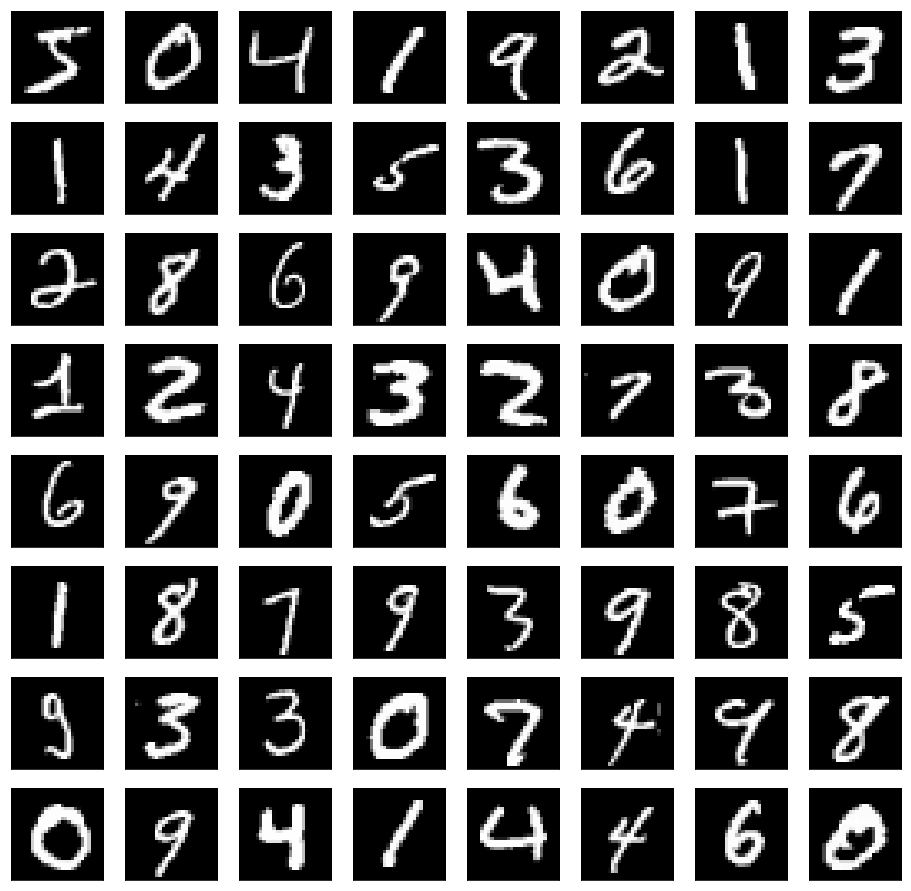

In [5]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(x[i], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
def plot_history(history):
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], history['d_loss'], label='discriminator loss')
    plt.plot(history['epoch'], history['g_loss'], label='generator loss')
    plt.title('loss during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], history['d_acc'], label='discriminator accuracy')
    plt.title('accuracy during training')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.show()

In [7]:
class GAN_:

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.loss = torch.nn.functional.binary_cross_entropy

        self.g = None
        self.d = None

    def fit(self, data_loader, epochs):
        self.g.to(self.device)
        self.d.to(self.device)
        history = {'epoch': [], 'g_loss': [], 'd_loss': [], 'd_acc': []}
        for epoch in range(1, epochs + 1):
            self.g.train()
            self.d.train()
            start_time = time.time()
            g_loss, d_loss, d_acc = 0, 0, 0
            for real_imgs, _ in data_loader:
                real = torch.Tensor(real_imgs.size(0), 1).fill_(0.9).to(self.device)
                fake = torch.Tensor(real_imgs.size(0), 1).fill_(0.0).to(self.device)
                real_imgs = real_imgs.to(self.device)
                fake_imgs = self.g(
                    torch.Tensor(np.random.normal(0, 1, (real_imgs.size(0), 100))).to(self.device))
                # Train discriminator
                self.d.optimizer.zero_grad()
                real_out = self.d(real_imgs)
                fake_out = self.d(fake_imgs.detach())
                d_loss_ = (self.loss(real_out, real) + self.loss(fake_out, fake)) / 2
                d_loss_.backward()
                self.d.optimizer.step()
                # Train generator
                self.g.optimizer.zero_grad()
                g_loss_ = self.loss(self.d(fake_imgs), real)
                g_loss_.backward()
                self.g.optimizer.step()
                # Calculate metrics for batch
                g_loss += float(g_loss_) * len(real_imgs)
                d_loss += float(d_loss_) * len(real_imgs)
                d_acc += int((real_out >= 0.5).sum()) + int((fake_out < 0.5).sum())
            # Calculate metrics for epoch
            g_loss /= len(data_loader.dataset)
            d_loss /= len(data_loader.dataset)
            d_acc /= 2 * len(data_loader.dataset)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['g_loss'].append(g_loss)
            history['d_loss'].append(d_loss)
            history['d_acc'].append(d_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - g_loss: {g_loss:.4f} - d_loss: {d_loss:.4f} - d_acc: {d_acc:.4f}')

            if epoch == 1 or epoch % 20 == 0 or epoch == epochs:
                fake_imgs = self.g(
                    torch.Tensor(np.random.normal(0, 1, (24, 100))).to(self.device)).detach().cpu()
                plt.figure(figsize=(16, 6))
                for i in range(24):
                    plt.subplot(3, 8, i + 1)
                    plt.imshow(fake_imgs[i], cmap=plt.cm.gray)
                    plt.xticks([])
                    plt.yticks([])
                plt.show()

        return history

In [8]:
class GAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Linear(100, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(256),
                    torch.nn.Linear(256, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(512),
                    torch.nn.Linear(512, 1024),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.BatchNorm1d(1024),
                    torch.nn.Linear(1024, 784),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(784, 512),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(512, 256),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout(0.3),
                    torch.nn.Linear(256, 1),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), -1)
                for layer in self.layers:
                    x = layer(x)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [9]:
model = GAN()

[  1/100] 12.7s - g_loss: 0.9130 - d_loss: 0.5994 - d_acc: 0.7040


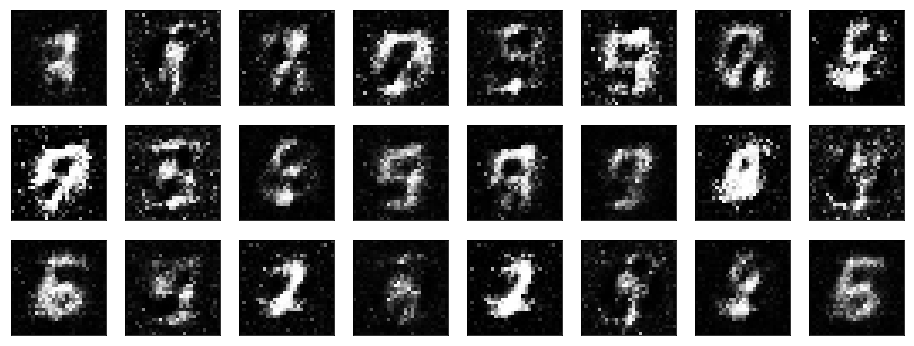

[  2/100] 11.9s - g_loss: 0.9513 - d_loss: 0.6250 - d_acc: 0.6624
[  3/100] 11.8s - g_loss: 0.9542 - d_loss: 0.6289 - d_acc: 0.6532
[  4/100] 11.7s - g_loss: 0.8780 - d_loss: 0.6567 - d_acc: 0.6071
[  5/100] 11.6s - g_loss: 0.8505 - d_loss: 0.6672 - d_acc: 0.5856
[  6/100] 11.7s - g_loss: 0.8320 - d_loss: 0.6743 - d_acc: 0.5659
[  7/100] 11.7s - g_loss: 0.8221 - d_loss: 0.6771 - d_acc: 0.5572
[  8/100] 11.9s - g_loss: 0.8198 - d_loss: 0.6791 - d_acc: 0.5508
[  9/100] 11.8s - g_loss: 0.8164 - d_loss: 0.6803 - d_acc: 0.5452
[ 10/100] 11.7s - g_loss: 0.8122 - d_loss: 0.6808 - d_acc: 0.5445
[ 11/100] 11.7s - g_loss: 0.8112 - d_loss: 0.6812 - d_acc: 0.5426
[ 12/100] 11.7s - g_loss: 0.8097 - d_loss: 0.6813 - d_acc: 0.5407
[ 13/100] 11.9s - g_loss: 0.8094 - d_loss: 0.6808 - d_acc: 0.5415
[ 14/100] 11.8s - g_loss: 0.8071 - d_loss: 0.6820 - d_acc: 0.5393
[ 15/100] 11.7s - g_loss: 0.8061 - d_loss: 0.6816 - d_acc: 0.5392
[ 16/100] 11.6s - g_loss: 0.8057 - d_loss: 0.6826 - d_acc: 0.5341
[ 17/100] 

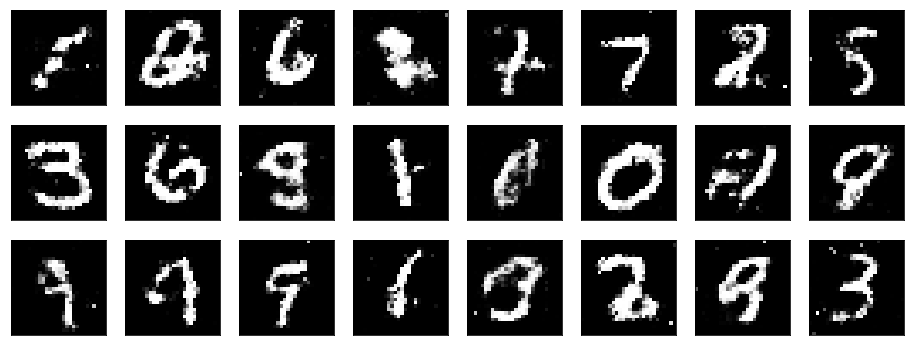

[ 21/100] 11.8s - g_loss: 0.8028 - d_loss: 0.6827 - d_acc: 0.5337
[ 22/100] 11.7s - g_loss: 0.8024 - d_loss: 0.6827 - d_acc: 0.5317
[ 23/100] 12.0s - g_loss: 0.8012 - d_loss: 0.6834 - d_acc: 0.5297
[ 24/100] 11.9s - g_loss: 0.8006 - d_loss: 0.6828 - d_acc: 0.5306
[ 25/100] 11.7s - g_loss: 0.8010 - d_loss: 0.6828 - d_acc: 0.5316
[ 26/100] 11.8s - g_loss: 0.8004 - d_loss: 0.6831 - d_acc: 0.5314
[ 27/100] 11.7s - g_loss: 0.8014 - d_loss: 0.6829 - d_acc: 0.5313
[ 28/100] 11.9s - g_loss: 0.7997 - d_loss: 0.6831 - d_acc: 0.5295
[ 29/100] 11.7s - g_loss: 0.7981 - d_loss: 0.6834 - d_acc: 0.5277
[ 30/100] 11.9s - g_loss: 0.7996 - d_loss: 0.6832 - d_acc: 0.5287
[ 31/100] 11.8s - g_loss: 0.8004 - d_loss: 0.6835 - d_acc: 0.5279
[ 32/100] 11.8s - g_loss: 0.7978 - d_loss: 0.6840 - d_acc: 0.5269
[ 33/100] 11.9s - g_loss: 0.7985 - d_loss: 0.6837 - d_acc: 0.5275
[ 34/100] 11.8s - g_loss: 0.7966 - d_loss: 0.6840 - d_acc: 0.5264
[ 35/100] 11.8s - g_loss: 0.7961 - d_loss: 0.6845 - d_acc: 0.5253
[ 36/100] 

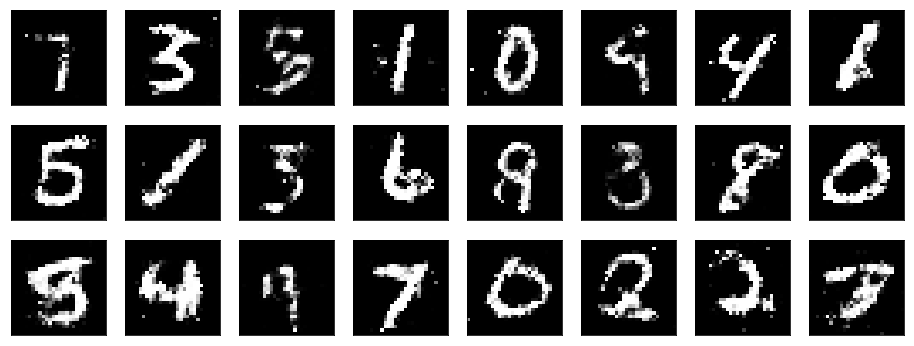

[ 41/100] 11.7s - g_loss: 0.7964 - d_loss: 0.6842 - d_acc: 0.5251
[ 42/100] 11.7s - g_loss: 0.7956 - d_loss: 0.6839 - d_acc: 0.5260
[ 43/100] 11.9s - g_loss: 0.7954 - d_loss: 0.6841 - d_acc: 0.5248
[ 44/100] 11.7s - g_loss: 0.7946 - d_loss: 0.6847 - d_acc: 0.5218
[ 45/100] 11.7s - g_loss: 0.7955 - d_loss: 0.6847 - d_acc: 0.5223
[ 46/100] 11.7s - g_loss: 0.7944 - d_loss: 0.6845 - d_acc: 0.5227
[ 47/100] 11.8s - g_loss: 0.7943 - d_loss: 0.6848 - d_acc: 0.5215
[ 48/100] 11.8s - g_loss: 0.7936 - d_loss: 0.6847 - d_acc: 0.5223
[ 49/100] 11.9s - g_loss: 0.7954 - d_loss: 0.6845 - d_acc: 0.5226
[ 50/100] 11.7s - g_loss: 0.7936 - d_loss: 0.6849 - d_acc: 0.5215
[ 51/100] 11.8s - g_loss: 0.7940 - d_loss: 0.6843 - d_acc: 0.5240
[ 52/100] 11.8s - g_loss: 0.7944 - d_loss: 0.6848 - d_acc: 0.5204
[ 53/100] 11.8s - g_loss: 0.7942 - d_loss: 0.6850 - d_acc: 0.5216
[ 54/100] 12.0s - g_loss: 0.7936 - d_loss: 0.6851 - d_acc: 0.5198
[ 55/100] 11.8s - g_loss: 0.7937 - d_loss: 0.6849 - d_acc: 0.5209
[ 56/100] 

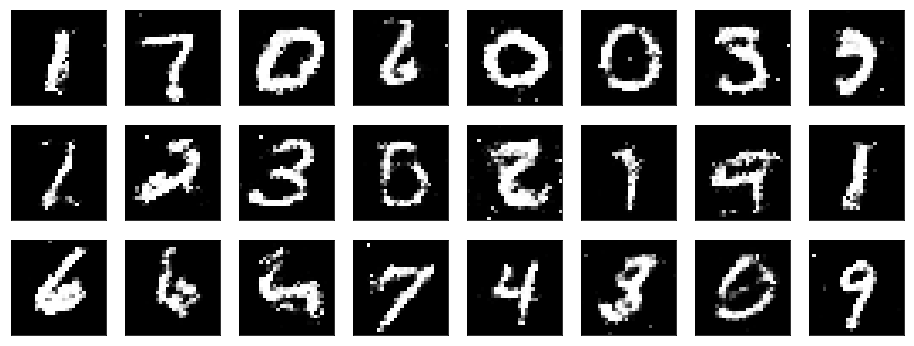

[ 61/100] 12.3s - g_loss: 0.7928 - d_loss: 0.6853 - d_acc: 0.5194
[ 62/100] 12.1s - g_loss: 0.7922 - d_loss: 0.6851 - d_acc: 0.5182
[ 63/100] 12.4s - g_loss: 0.7925 - d_loss: 0.6848 - d_acc: 0.5208
[ 64/100] 12.0s - g_loss: 0.7935 - d_loss: 0.6853 - d_acc: 0.5181
[ 65/100] 11.8s - g_loss: 0.7929 - d_loss: 0.6851 - d_acc: 0.5187
[ 66/100] 11.8s - g_loss: 0.7924 - d_loss: 0.6852 - d_acc: 0.5195
[ 67/100] 11.8s - g_loss: 0.7922 - d_loss: 0.6856 - d_acc: 0.5168
[ 68/100] 11.7s - g_loss: 0.7918 - d_loss: 0.6854 - d_acc: 0.5189
[ 69/100] 11.8s - g_loss: 0.7916 - d_loss: 0.6853 - d_acc: 0.5183
[ 70/100] 11.8s - g_loss: 0.7918 - d_loss: 0.6852 - d_acc: 0.5186
[ 71/100] 11.8s - g_loss: 0.7930 - d_loss: 0.6854 - d_acc: 0.5191
[ 72/100] 11.8s - g_loss: 0.7924 - d_loss: 0.6855 - d_acc: 0.5177
[ 73/100] 11.8s - g_loss: 0.7921 - d_loss: 0.6854 - d_acc: 0.5179
[ 74/100] 11.8s - g_loss: 0.7929 - d_loss: 0.6852 - d_acc: 0.5196
[ 75/100] 11.8s - g_loss: 0.7916 - d_loss: 0.6855 - d_acc: 0.5169
[ 76/100] 

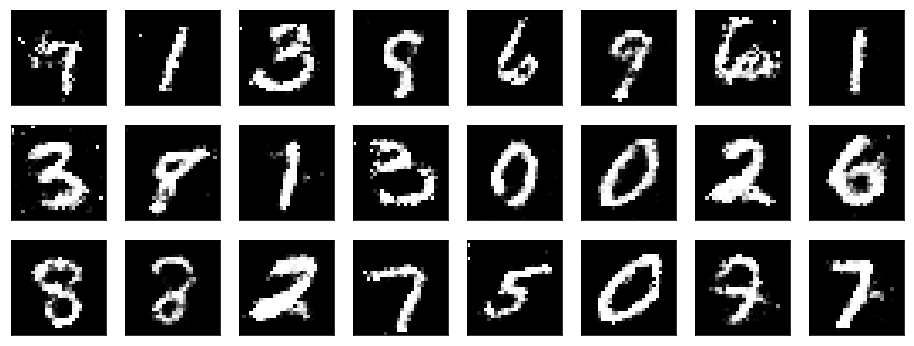

[ 81/100] 11.8s - g_loss: 0.7920 - d_loss: 0.6854 - d_acc: 0.5191
[ 82/100] 11.7s - g_loss: 0.7925 - d_loss: 0.6853 - d_acc: 0.5183
[ 83/100] 11.8s - g_loss: 0.7913 - d_loss: 0.6858 - d_acc: 0.5164
[ 84/100] 11.8s - g_loss: 0.7903 - d_loss: 0.6859 - d_acc: 0.5162
[ 85/100] 11.8s - g_loss: 0.7908 - d_loss: 0.6857 - d_acc: 0.5158
[ 86/100] 11.9s - g_loss: 0.7911 - d_loss: 0.6859 - d_acc: 0.5167
[ 87/100] 12.1s - g_loss: 0.7910 - d_loss: 0.6857 - d_acc: 0.5172
[ 88/100] 11.8s - g_loss: 0.7911 - d_loss: 0.6857 - d_acc: 0.5170
[ 89/100] 11.8s - g_loss: 0.7910 - d_loss: 0.6858 - d_acc: 0.5162
[ 90/100] 11.8s - g_loss: 0.7908 - d_loss: 0.6857 - d_acc: 0.5167
[ 91/100] 11.8s - g_loss: 0.7894 - d_loss: 0.6861 - d_acc: 0.5162
[ 92/100] 11.7s - g_loss: 0.7908 - d_loss: 0.6860 - d_acc: 0.5169
[ 93/100] 11.8s - g_loss: 0.7904 - d_loss: 0.6859 - d_acc: 0.5148
[ 94/100] 12.1s - g_loss: 0.7907 - d_loss: 0.6857 - d_acc: 0.5162
[ 95/100] 12.2s - g_loss: 0.7909 - d_loss: 0.6860 - d_acc: 0.5164
[ 96/100] 

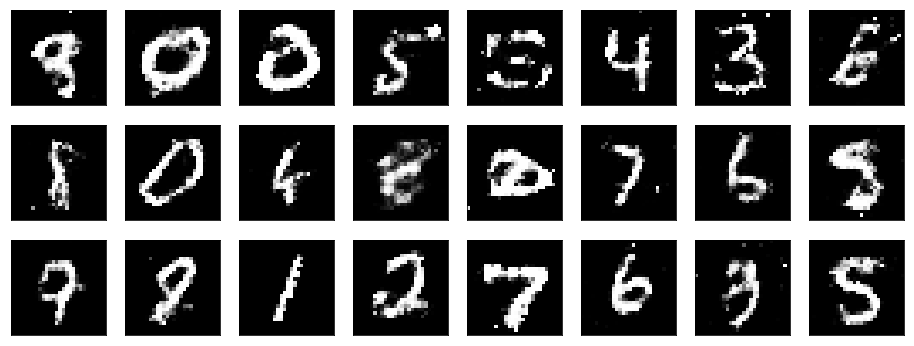

In [10]:
history = model.fit(data_loader, epochs=100)

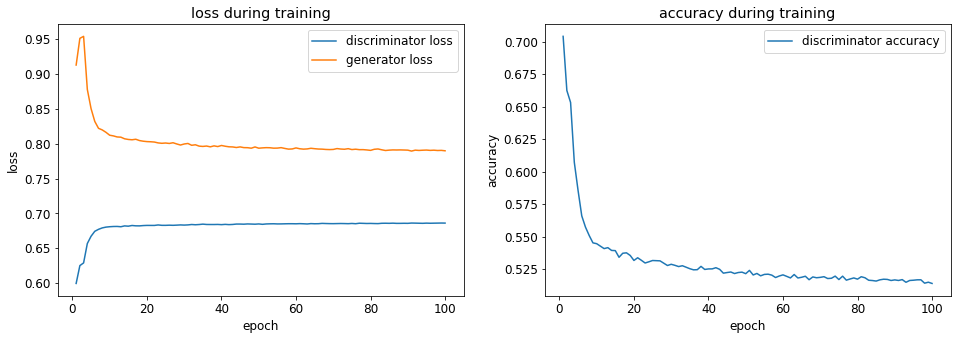

In [11]:
plot_history(history)

In [12]:
class DCGAN(GAN_):

    def __init__(self):
        super().__init__()

        class Generator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.ConvTranspose2d(100, 512, 4),
                    torch.nn.BatchNorm2d(512),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
                    torch.nn.BatchNorm2d(256),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=2),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.ReLU(),
                    torch.nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1),
                    torch.nn.Tanh(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), x.size(1), 1, 1)
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), 28, 28)
                return x

        class Discriminator(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.layers = torch.nn.ModuleList([
                    torch.nn.Conv2d(1, 32, 4, stride=2, padding=1),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.3),
                    torch.nn.Conv2d(32, 64, 4, stride=2, padding=2),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.3),
                    torch.nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    torch.nn.BatchNorm2d(128),
                    torch.nn.LeakyReLU(0.2),
                    torch.nn.Dropout2d(0.3),
                    torch.nn.Conv2d(128, 1, 4),
                    torch.nn.Sigmoid(),
                ])
                self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))
            def forward(self, x):
                x = x.view(x.size(0), 1, 28, 28)
                for layer in self.layers:
                    x = layer(x)
                x = x.view(x.size(0), -1)
                return x

        self.g = Generator()
        self.d = Discriminator()

In [13]:
model = DCGAN()

[  1/100] 46.8s - g_loss: 1.2327 - d_loss: 0.5980 - d_acc: 0.6671


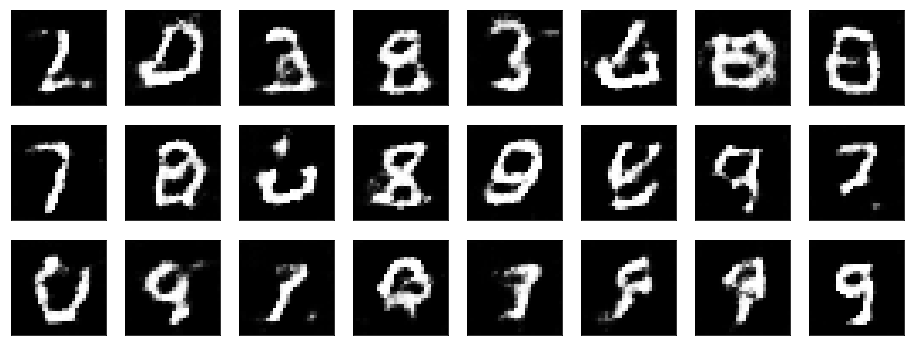

[  2/100] 47.0s - g_loss: 0.8422 - d_loss: 0.6763 - d_acc: 0.5594
[  3/100] 46.6s - g_loss: 0.8280 - d_loss: 0.6788 - d_acc: 0.5493
[  4/100] 46.6s - g_loss: 0.8195 - d_loss: 0.6802 - d_acc: 0.5449
[  5/100] 46.7s - g_loss: 0.8108 - d_loss: 0.6822 - d_acc: 0.5360
[  6/100] 46.6s - g_loss: 0.8087 - d_loss: 0.6832 - d_acc: 0.5320
[  7/100] 46.6s - g_loss: 0.8041 - d_loss: 0.6837 - d_acc: 0.5304
[  8/100] 46.7s - g_loss: 0.8031 - d_loss: 0.6840 - d_acc: 0.5286
[  9/100] 46.6s - g_loss: 0.8008 - d_loss: 0.6846 - d_acc: 0.5253
[ 10/100] 46.7s - g_loss: 0.7995 - d_loss: 0.6841 - d_acc: 0.5251
[ 11/100] 46.5s - g_loss: 0.7993 - d_loss: 0.6853 - d_acc: 0.5215
[ 12/100] 46.7s - g_loss: 0.7958 - d_loss: 0.6855 - d_acc: 0.5182
[ 13/100] 46.7s - g_loss: 0.7968 - d_loss: 0.6850 - d_acc: 0.5219
[ 14/100] 46.6s - g_loss: 0.7974 - d_loss: 0.6843 - d_acc: 0.5235
[ 15/100] 47.2s - g_loss: 0.7987 - d_loss: 0.6845 - d_acc: 0.5223
[ 16/100] 46.6s - g_loss: 0.7988 - d_loss: 0.6844 - d_acc: 0.5237
[ 17/100] 

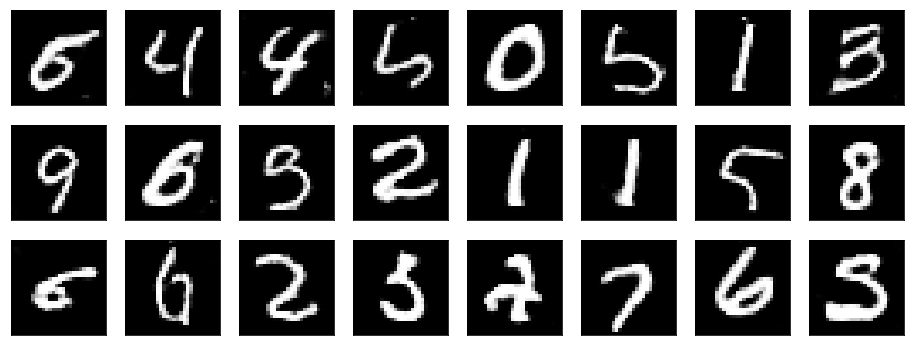

[ 21/100] 46.6s - g_loss: 0.7999 - d_loss: 0.6837 - d_acc: 0.5258
[ 22/100] 47.0s - g_loss: 0.8006 - d_loss: 0.6841 - d_acc: 0.5244
[ 23/100] 46.8s - g_loss: 0.7962 - d_loss: 0.6854 - d_acc: 0.5180
[ 24/100] 46.7s - g_loss: 0.7971 - d_loss: 0.6842 - d_acc: 0.5228
[ 25/100] 46.5s - g_loss: 0.7978 - d_loss: 0.6845 - d_acc: 0.5209
[ 26/100] 46.7s - g_loss: 0.7981 - d_loss: 0.6837 - d_acc: 0.5239
[ 27/100] 46.7s - g_loss: 0.7979 - d_loss: 0.6834 - d_acc: 0.5267
[ 28/100] 46.7s - g_loss: 0.7991 - d_loss: 0.6836 - d_acc: 0.5251
[ 29/100] 46.5s - g_loss: 0.8003 - d_loss: 0.6829 - d_acc: 0.5271
[ 30/100] 46.7s - g_loss: 0.7998 - d_loss: 0.6839 - d_acc: 0.5254
[ 31/100] 46.7s - g_loss: 0.7998 - d_loss: 0.6839 - d_acc: 0.5257
[ 32/100] 46.7s - g_loss: 0.7989 - d_loss: 0.6844 - d_acc: 0.5226
[ 33/100] 46.5s - g_loss: 0.8012 - d_loss: 0.6829 - d_acc: 0.5277
[ 34/100] 46.6s - g_loss: 0.8011 - d_loss: 0.6830 - d_acc: 0.5280
[ 35/100] 46.7s - g_loss: 0.8004 - d_loss: 0.6822 - d_acc: 0.5296
[ 36/100] 

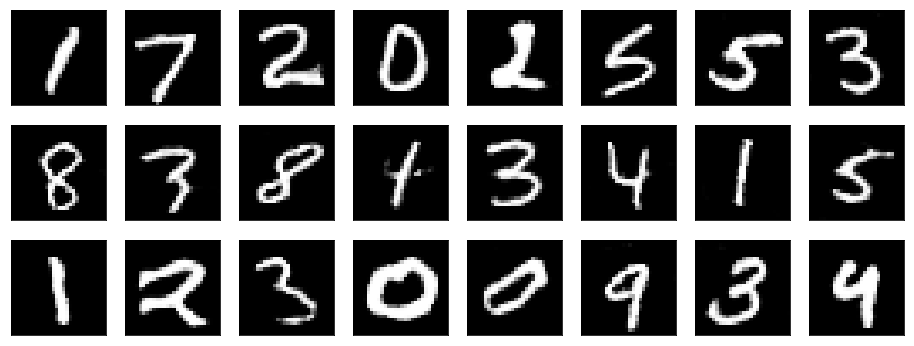

[ 41/100] 46.7s - g_loss: 0.8015 - d_loss: 0.6826 - d_acc: 0.5292
[ 42/100] 46.7s - g_loss: 0.8013 - d_loss: 0.6816 - d_acc: 0.5334
[ 43/100] 46.6s - g_loss: 0.8018 - d_loss: 0.6830 - d_acc: 0.5308
[ 44/100] 46.7s - g_loss: 0.8032 - d_loss: 0.6824 - d_acc: 0.5297
[ 45/100] 46.7s - g_loss: 0.8020 - d_loss: 0.6832 - d_acc: 0.5286
[ 46/100] 46.8s - g_loss: 0.8017 - d_loss: 0.6823 - d_acc: 0.5309
[ 47/100] 46.6s - g_loss: 0.8038 - d_loss: 0.6824 - d_acc: 0.5308
[ 48/100] 46.7s - g_loss: 0.8027 - d_loss: 0.6823 - d_acc: 0.5308
[ 49/100] 46.7s - g_loss: 0.8044 - d_loss: 0.6823 - d_acc: 0.5304
[ 50/100] 46.7s - g_loss: 0.8042 - d_loss: 0.6814 - d_acc: 0.5340
[ 51/100] 46.7s - g_loss: 0.8045 - d_loss: 0.6812 - d_acc: 0.5364
[ 52/100] 46.6s - g_loss: 0.8066 - d_loss: 0.6808 - d_acc: 0.5358
[ 53/100] 46.7s - g_loss: 0.8071 - d_loss: 0.6814 - d_acc: 0.5356
[ 54/100] 46.7s - g_loss: 0.8051 - d_loss: 0.6819 - d_acc: 0.5326
[ 55/100] 46.8s - g_loss: 0.8033 - d_loss: 0.6818 - d_acc: 0.5337
[ 56/100] 

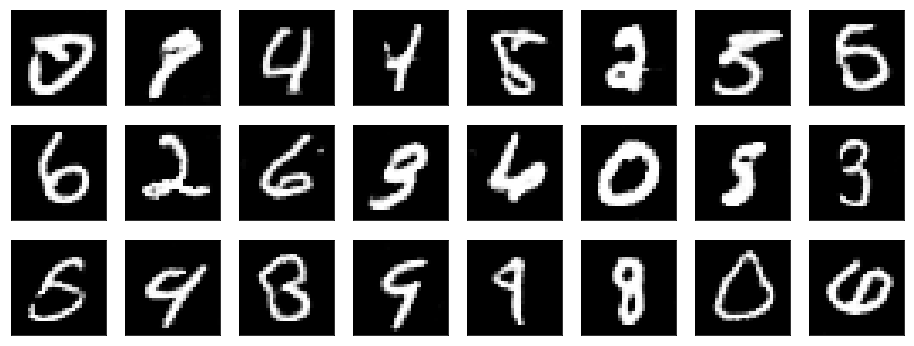

[ 61/100] 46.6s - g_loss: 0.8046 - d_loss: 0.6815 - d_acc: 0.5349
[ 62/100] 46.6s - g_loss: 0.8044 - d_loss: 0.6825 - d_acc: 0.5327
[ 63/100] 46.6s - g_loss: 0.8054 - d_loss: 0.6811 - d_acc: 0.5368
[ 64/100] 46.7s - g_loss: 0.8049 - d_loss: 0.6817 - d_acc: 0.5371
[ 65/100] 46.4s - g_loss: 0.8043 - d_loss: 0.6810 - d_acc: 0.5358
[ 66/100] 46.7s - g_loss: 0.8045 - d_loss: 0.6813 - d_acc: 0.5354
[ 67/100] 46.6s - g_loss: 0.8047 - d_loss: 0.6820 - d_acc: 0.5331
[ 68/100] 46.6s - g_loss: 0.8082 - d_loss: 0.6797 - d_acc: 0.5397
[ 69/100] 46.7s - g_loss: 0.8069 - d_loss: 0.6812 - d_acc: 0.5366
[ 70/100] 46.5s - g_loss: 0.8078 - d_loss: 0.6802 - d_acc: 0.5393
[ 71/100] 46.6s - g_loss: 0.8046 - d_loss: 0.6813 - d_acc: 0.5363
[ 72/100] 46.6s - g_loss: 0.8079 - d_loss: 0.6797 - d_acc: 0.5420
[ 73/100] 46.6s - g_loss: 0.8053 - d_loss: 0.6814 - d_acc: 0.5372
[ 74/100] 46.5s - g_loss: 0.8082 - d_loss: 0.6805 - d_acc: 0.5376
[ 75/100] 46.6s - g_loss: 0.8073 - d_loss: 0.6804 - d_acc: 0.5384
[ 76/100] 

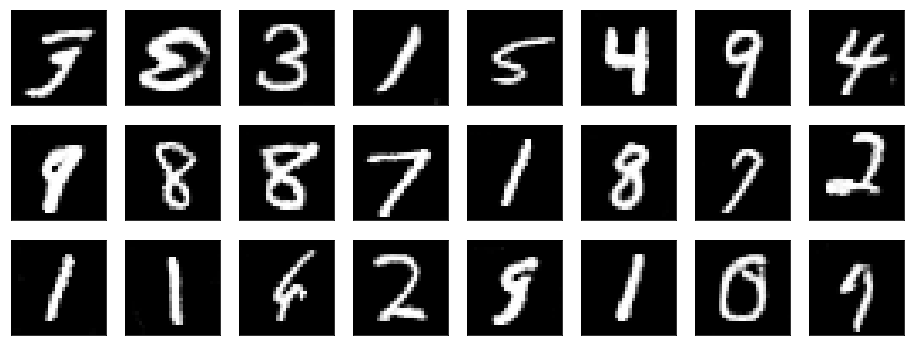

[ 81/100] 46.6s - g_loss: 0.8052 - d_loss: 0.6815 - d_acc: 0.5355
[ 82/100] 46.6s - g_loss: 0.8075 - d_loss: 0.6807 - d_acc: 0.5360
[ 83/100] 46.4s - g_loss: 0.8067 - d_loss: 0.6817 - d_acc: 0.5336
[ 84/100] 46.6s - g_loss: 0.8065 - d_loss: 0.6817 - d_acc: 0.5342
[ 85/100] 46.6s - g_loss: 0.8042 - d_loss: 0.6816 - d_acc: 0.5341
[ 86/100] 46.6s - g_loss: 0.8060 - d_loss: 0.6827 - d_acc: 0.5321
[ 87/100] 46.5s - g_loss: 0.8037 - d_loss: 0.6825 - d_acc: 0.5325
[ 88/100] 46.6s - g_loss: 0.8061 - d_loss: 0.6816 - d_acc: 0.5327
[ 89/100] 46.6s - g_loss: 0.8044 - d_loss: 0.6820 - d_acc: 0.5351
[ 90/100] 46.6s - g_loss: 0.8048 - d_loss: 0.6815 - d_acc: 0.5340
[ 91/100] 46.6s - g_loss: 0.8060 - d_loss: 0.6806 - d_acc: 0.5368
[ 92/100] 46.5s - g_loss: 0.8045 - d_loss: 0.6812 - d_acc: 0.5359
[ 93/100] 46.6s - g_loss: 0.8070 - d_loss: 0.6805 - d_acc: 0.5401
[ 94/100] 46.6s - g_loss: 0.8069 - d_loss: 0.6812 - d_acc: 0.5370
[ 95/100] 46.6s - g_loss: 0.8042 - d_loss: 0.6823 - d_acc: 0.5314
[ 96/100] 

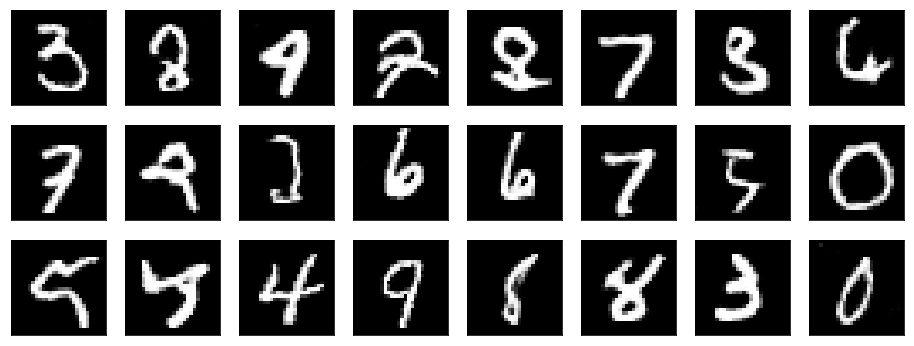

In [14]:
history = model.fit(data_loader, epochs=100)

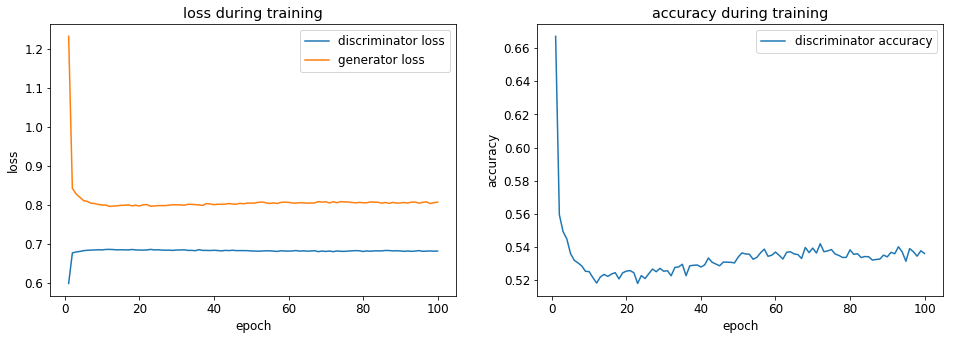

In [15]:
plot_history(history)